In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import cross_val_score
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
import pingouin as pg
import seaborn as sns
from scipy.interpolate import Rbf

In [2]:
df = pd.read_csv('allTogether.csv')

# remove ids and numbers
#df = df.drop(['_id','question.number','user._id'], axis=1)
# groupNames, majLabel and colors are synonyms
df = df.drop(['question.groupNames','question.colors'], axis=1)

# rND' is labeled in reverse
df['question.new_rND'] = 2 - df['question.new_rND']

# add absolute version of the cv score (demographic parity)
df['question.abs_cv'] = df['question.cv']
df.loc[df['question.cv']>1, 'question.abs_cv'] = 2-df['question.cv']

# add gender-focused version of the cv score (demographic parity)
# S=1 for male personas, S=0 for female personas
df['question.gender_cv'] = df['question.cv']
df.loc[df['question.majLabel']=='female', 'question.gender_cv'] = 2-df['question.cv']
# S=0 for female personas, S=1 for male personas
df['question.inverse_gender_cv'] = df['question.cv']
df.loc[df['question.majLabel']=='male', 'question.inverse_gender_cv'] = 2-df['question.cv']

# add gender-focused version of the rND score (demographic parity)
# S=1 for male personas, S=0 for female personas
df['question.gender_rND'] = df['question.new_rND']
df.loc[df['question.majLabel']=='female', 'question.gender_rND'] = 2-df['question.new_rND']
# S=0 for female personas, S=1 for male personas
df['question.inverse_gender_rND'] = df['question.new_rND']
df.loc[df['question.majLabel']=='male', 'question.inverse_gender_rND'] = 2-df['question.new_rND']

# add absolute versions of comparative accuracy scores
df['question.abs_s_tnr'] = df['question.s_tnr']
df.loc[df['question.s_tnr']>1, 'question.abs_s_tnr'] = 2-df['question.s_tnr']
df['question.abs_s_tpr'] = df['question.s_tpr']
df.loc[df['question.s_tpr']>1, 'question.abs_s_tpr'] = 2-df['question.s_tpr']
df['question.abs_s_bcr'] = df['question.s_bcr']
df.loc[df['question.s_bcr']>1, 'question.abs_s_bcr'] = 2-df['question.s_bcr']

# add absolute versions of comparative adjusted accuracy scores
df['question.abs_s_adj_tnr'] = df['question.s_adj_tnr']
df.loc[df['question.s_adj_tnr']>1, 'question.abs_s_adj_tnr'] = 2-df['question.s_adj_tnr']
df['question.abs_s_adj_tpr'] = df['question.s_adj_tpr']
df.loc[df['question.s_adj_tpr']>1, 'question.abs_s_adj_tpr'] = 2-df['question.s_adj_tpr']
df['question.abs_s_adj_bcr'] = df['question.s_adj_bcr']
df.loc[df['question.s_adj_bcr']>1, 'question.abs_s_adj_bcr'] = 2-df['question.s_adj_bcr']

# add persona count: 10 men - 5 men, 5 women - 10 women
df['question.n_women'] = df['question.minSize']/10
df.loc[df['question.majLabel']=='female', 'question.n_women'] = df['question.majSize']/10

pd.set_option('display.max_columns', None)
df.head()

,_id,rating,inconfidence,secondsElapsed,question.questionType,question.number,question.minSize,question.majSize,question.majLabel,question.tpr,question.tnr,question.bcr,question.accuracy,question.adj_tpr,question.adj_tnr,question.adj_bcr,question.adj_accuracy,question.tpr0,question.tnr0,question.bcr0,question.accuracy0,question.adj_tpr0,question.adj_tnr0,question.adj_bcr0,question.adj_accuracy0,question.tpr1,question.tnr1,question.bcr1,question.accuracy1,question.adj_tpr1,question.adj_tnr1,question.adj_bcr1,question.adj_accuracy1,question.s_tpr,question.s_tnr,question.s_bcr,question.s_accuracy,question.s_adj_tpr,question.s_adj_tnr,question.s_adj_bcr,question.s_adj_accuracy,question.cv,question.cluster,question.ordering_utility,question.sum_of_diff,question.rND,question.new_rND,user._id,user.language,user.accuracy,user.age,user.believe,user.comparativeAccuracy,user.confidence,user.edu,user.fear,user.gender,user.genderParity,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.abs_cv,question.gender_cv,question.inverse_gender_cv,question.gender_rND,question.inverse_gender_rND,question.abs_s_tnr,question.abs_s_tpr,question.abs_s_bcr,question.abs_s_adj_tnr,question.abs_s_adj_tpr,question.abs_s_adj_bcr,question.n_women
0,ObjectId(5f3500c84f6d2fc080cfe347),0.89,0.84,36.534,selection,719,3,7,female,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.00,1.000000,NaN,NaN,1.000000,1.0,1.0,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.714286,3,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.285714,0.285714,1.714286,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,0.7
1,ObjectId(5f3500d94f6d2fc080cfe34d),0.58,NaN,16.849,selection,944,5,5,female,0.833333,0.750000,0.791667,0.8,0.927083,0.833333,0.880208,0.898551,0.666667,1.000000,0.833333,0.80,0.854167,1.000000,0.927083,0.898551,1.0,0.5,0.75,0.800000,1.000000,0.666667,0.833333,0.898551,0.666667,1.500000,1.083333,1.000000,0.854167,1.333333,1.093750,1.000000,0.600000,8,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.600000,1.400000,0.600000,NaN,NaN,0.500000,0.666667,0.916667,0.666667,0.854167,0.906250,0.5
2,ObjectId(5f3500e64f6d2fc080cfe351),0.39,0.06,12.849,selection,282,4,6,male,0.666667,0.857143,0.761905,0.8,0.774194,0.885246,0.829720,0.862745,1.000000,0.666667,0.833333,0.75,1.000000,0.791045,0.895522,0.827160,0.5,1.0,0.75,0.833333,0.730769,1.000000,0.865385,0.921348,1.500000,0.666667,1.083333,0.916667,1.269231,0.791045,1.030138,0.905812,1.333333,7,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.666667,1.333333,0.666667,NaN,NaN,0.666667,0.500000,0.916667,0.791045,0.730769,0.969862,0.4
3,ObjectId(5f3500f14f6d2fc080cfe355),0.25,NaN,10.424,selection,556,4,6,female,0.500000,0.666667,0.583333,0.6,0.565217,0.813725,0.689471,0.736486,0.333333,1.000000,0.666667,0.50,0.395349,1.000000,0.697674,0.500000,1.0,0.6,0.80,0.666667,1.000000,0.747967,0.873984,0.770370,0.333333,1.400000,0.866667,0.833333,0.395349,1.252033,0.823691,0.729630,0.750000,2,NaN,NaN,NaN,NaN,ObjectId(5f350096c9eafb2f751e4c21),de,0.86,25,0.37,0.34,0.74,abitur,0.5,male,0.73,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.750000,1.250000,0.750000,NaN,NaN,0.600000,0.333333,0.866667,0.747967,0.395349,0.823691,0.6
4,ObjectId(5f3500f94f6d2fc080cfe359),0.05,0.13,8.199,selection,52,1,9,female,0.000000,0.888889,0.444444,0.8,0.000000,0.857143,0.428571,0.825911,NaN,0.000000,NaN,0.00,NaN,0.000000,NaN,0.000000,0.0,1.0,0.50,0.888889,0.000000,1.000000,0.500000,0.957746,NaN,0.000000,NaN,0.111111,NaN,0.000000,NaN,0.042254,2.000000,0,NaN,NaN,NaN,NaN,ObjectId(5f3500

In [3]:
cat_cols = [
    'question.majLabel',
    'question.questionType',
    'user.language',
    'user.age',
    'user.edu',
    'user.gender',
]
num_cols = [
    'secondsElapsed',
    'question.minSize',
    'question.majSize',
    'question.n_women',
    'user.believe',
    'user.confidence',
    'user.fear',
    'user.political',
    'user.religious',
    'user.screenHeight',
    'user.screenWidth',
    'user.will',
    'user.agreeableness',
    'user.conscientiousness',
    'user.extraversion',
    'user.neuroticism',
    'user.openness',
]
num_cols_sel = [
    'question.tpr',
    'question.tnr',
    'question.bcr',
    'question.accuracy',
    'question.adj_tpr',
    'question.adj_tnr',
    'question.adj_bcr',
    'question.adj_accuracy',
    'question.tpr0',
    'question.tnr0',
    'question.bcr0',
    'question.accuracy0',
    'question.adj_tpr0',
    'question.adj_tnr0',
    'question.adj_bcr0',
    'question.adj_accuracy0',
    'question.tpr1',
    'question.tnr1',
    'question.bcr1',
    'question.accuracy1',
    'question.adj_tpr1',
    'question.adj_tnr1',
    'question.adj_bcr1',
    'question.adj_accuracy1',
    'question.s_tpr',
    'question.s_tnr',
    'question.s_bcr',
    'question.s_accuracy',
    'question.s_adj_tpr',
    'question.s_adj_tnr',
    'question.s_adj_bcr',
    'question.s_adj_accuracy',
    'question.abs_s_tpr',
    'question.abs_s_tnr',
    'question.abs_s_bcr',
    'question.abs_s_adj_tpr',
    'question.abs_s_adj_tnr',
    'question.abs_s_adj_bcr',
    'question.cv',
    'question.abs_cv',
    'question.gender_cv',
    'question.inverse_gender_cv'
]
num_cols_ran = [
    'question.ordering_utility',
    'question.sum_of_diff',
    'question.new_rND',
    'question.gender_rND',
]
# don't use the following attributes in the model
    #'inconfidence',
    #'question.cluster',
    #'user.accuracy',
    #'user.comparativeAccuracy',
    #'user.genderParity',

# split dataset according to questionType
df_ran = df.query("`question.questionType` == 'ranking'")[['rating'] + num_cols + num_cols_ran + cat_cols]
df_sel = df.query("`question.questionType` == 'selection'")[['rating'] + num_cols + num_cols_sel + cat_cols]
df_sel[:10]

,rating,secondsElapsed,question.minSize,question.majSize,question.n_women,user.believe,user.confidence,user.fear,user.political,user.religious,user.screenHeight,user.screenWidth,user.will,user.agreeableness,user.conscientiousness,user.extraversion,user.neuroticism,user.openness,question.tpr,question.tnr,question.bcr,question.accuracy,question.adj_tpr,question.adj_tnr,question.adj_bcr,question.adj_accuracy,question.tpr0,question.tnr0,question.bcr0,question.accuracy0,question.adj_tpr0,question.adj_tnr0,question.adj_bcr0,question.adj_accuracy0,question.tpr1,question.tnr1,question.bcr1,question.accuracy1,question.adj_tpr1,question.adj_tnr1,question.adj_bcr1,question.adj_accuracy1,question.s_tpr,question.s_tnr,question.s_bcr,question.s_accuracy,question.s_adj_tpr,question.s_adj_tnr,question.s_adj_bcr,question.s_adj_accuracy,question.abs_s_tpr,question.abs_s_tnr,question.abs_s_bcr,question.abs_s_adj_tpr,question.abs_s_adj_tnr,question.abs_s_adj_bcr,question.cv,question.abs_cv,question.gender_cv,question.inverse_gender_cv,question.majLabel,question.questionType,user.language,user.age,user.edu,user.gender
0,0.89,36.534,3,7,0.7,0.37,0.74,0.5,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.0,1.0,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN,1.714286,0.285714,0.285714,1.714286,female,selection,de,25,abitur,male
1,0.58,16.849,5,5,0.5,0.37,0.74,0.5,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.833333,0.750000,0.791667,0.8,0.927083,0.833333,0.880208,0.898551,0.666667,1.000000,0.833333,0.800000,0.854167,1.000000,0.927083,0.898551,1.0,0.5,0.75,0.800000,1.000000,0.666667,0.833333,0.898551,0.666667,1.500000,1.083333,1.000000,0.854167,1.333333,1.093750,1.000000,0.666667,0.500000,0.916667,0.854167,0.666667,0.906250,0.600000,0.600000,1.400000,0.600000,female,selection,de,25,abitur,male
2,0.39,12.849,4,6,0.4,0.37,0.74,0.5,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.666667,0.857143,0.761905,0.8,0.774194,0.885246,0.829720,0.862745,1.000000,0.666667,0.833333,0.750000,1.000000,0.791045,0.895522,0.827160,0.5,1.0,0.75,0.833333,0.730769,1.000000,0.865385,0.921348,1.500000,0.666667,1.083333,0.916667,1.269231,0.791045,1.030138,0.905812,0.500000,0.666667,0.916667,0.730769,0.791045,0.969862,1.333333,0.666667,1.333333,0.666667,male,selection,de,25,abitur,male
3,0.25,10.424,4,6,0.6,0.37,0.74,0.5,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.500000,0.666667,0.583333,0.6,0.565217,0.813725,0.689471,0.736486,0.333333,1.000000,0.666667,0.500000,0.395349,1.000000,0.697674,0.500000,1.0,0.6,0.80,0.666667,1.000000,0.747967,0.873984,0.770370,0.333333,1.400000,0.866667,0.833333,0.395349,1.252033,0.823691,0.729630,0.333333,0.600000,0.866667,0.395349,0.747967,0.823691,0.750000,0.750000,1.250000,0.750000,female,selection,de,25,abitur,male
4,0.05,8.199,1,9,0.9,0.37,0.74,0.5,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.000000,0.888889,0.444444,0.8,0.000000,0.857143,0.428571,0.825911,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.0,1.0,0.50,0.888889,0.000000,1.000000,0.500000,0.957746,NaN,0.000000,NaN,0.111111,NaN,0.000000,NaN,0.042254,NaN,0.000000,NaN,NaN,0.000000,NaN,2.000000,0.000000,0.000000,2.000000,female,selection,de,25,abitur,male
5,0.77,27.466,4,6,0.6,0.37,0.74,0.5,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.833333,0.750000,0.791667,0.8,0.937500,0.836735,0.887117,0.906832,1.000000,0.666667,0.833333,0.750000,1.000000,0.766667,0.883333,0.810811,0.8,1.0,0.90,0.833333,0.929293,1.000000,0.964646,0.933962,1.200000,0.666667,0.933333,0.916667,1.070707,0.766667,0.918687,0.876849,0.800000,0.666667,0.933333,0.929293,0.766667,0.918687,0.833333,0.833333,1.166667,0.833333,female,selection,de,25,abitur,male
6,0.21,5.064,3,7,0.3,0.37,0.74,0.5,0.78,0.13,1080,1920,0.82,3.0,1.5,3.5,2.5,4.0,0.000000,0.750000,0.375000,0.6,0.000000,0.805755,0.402878,0.682927,NaN,0.33333

In [20]:
def print_heatmap(x, y, z, width = 2, height = 1, xlabel = "cv", ylabel = "adj_accuracy"):
    
    XI, YI = np.meshgrid(np.linspace(0, width, width*100), np.linspace(0, height, height*100))

    # initialize radial basis function
    rbf = Rbf(x, y, z, smooth=0.01, epsilon=.001) # smooth to handle (incompatible near) duplicates
    ZI = rbf(XI, YI)

    # cap interpolated values within [0,1]
    np.putmask(ZI, ZI < 0, 0)
    np.putmask(ZI, ZI > 1, 1)

    # plotting
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_aspect('equal')
    m = ax.contourf(XI, YI, ZI, 100, cmap=plt.cm.RdYlBu, vmin=0, vmax=1)
    ax.scatter(x, y, c=z, s=15, cmap=m.cmap, edgecolors='black', linewidths=.4, alpha=1)
    cb = fig.colorbar(m, shrink=.5, ticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    cb.set_label('fairness rating')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    

def print_discrete_heatmap(data, x, y, z='rating', width=None, height=None,
                           xlabel=None, ylabel=None, title=None, detail=10, cmap=plt.cm.RdYlBu):

    # find width and height if undefined
    if (not width):
        width = round(np.max(data[x])-np.min(data[x]))
    if (not height):
        height = round(np.max(data[y])-np.min(data[y]))
        
    
    # prepare matrices
    x_values = data[x].reset_index(drop = True)
    y_values = data[y].reset_index(drop = True)
    z_pre_values = data[z].reset_index(drop = True)
    z_values = np.full((height*detail, width*detail, 1000), np.nan)
    z_sum = np.full((height*detail, width*detail), -1)
    z_mean = np.full((height*detail, width*detail), np.nan)
    z_std = np.full((height*detail, width*detail), np.nan)
    
    # sums of ratings
    for i in range(len(x_values)):
        col = int(np.round(y_values[i]*detail))
        row = int(np.round(x_values[i]*detail))
        if (row == width*detail):
            row = width*detail - 1
        if (col == height*detail):
            col = height*detail -1
        z_sum[col,row] += 1
        z_values[col, row, z_sum[col, row]] = z_pre_values[i]

    # mean ratings if not np.nan
    z_mean = np.nanmean(z_values, axis=2)
    z_std = np.nanstd(z_values, axis=2)
    mean_std = np.nanmean(z_std)
    print('Mean std. dev.:', mean_std)

    # plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal')
    y_grid, x_grid = np.mgrid[slice(0, height+1/detail, 1/detail), slice(0, width+1/detail, 1/detail)]
    m = ax.pcolor(x_grid, y_grid, z_mean, cmap=cmap, vmin=0, vmax=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom="on", left="on")
    cb = fig.colorbar(m, shrink=.5, ticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    cb.outline.set_visible(False)
    cb.set_label('fairness rating')
    if(xlabel):
        ax.set_xlabel(xlabel)
    else:
        ax.set_xlabel(x)
    if(ylabel):
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel(y)
    if(title):
        ax.set_title(title)
    fig.show()
    fig.savefig('heatmap.png', dpi=300)

    
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

def print_discrete_diff_heatmap(data, x, y, z='rating', data2=None, x2=None, y2=None, width=None, height=None,
                                xlabel=None, ylabel=None, title=None, detail=10):

    # find width and height if undefined
    if (not width):
        width = round(np.max(data[x])-np.min(data[x]))
    if (not height):
        height = round(np.max(data[y])-np.min(data[y]))
    if (data2 is None):
        data2 = data
    if (not x2):
        x2 = x
    if (not y2):
        y2 = y
        
    
    # prepare matrices
    x_values = data[x].reset_index(drop = True)
    y_values = data[y].reset_index(drop = True)
    z_pre_values = data[z].reset_index(drop = True)
    z_values = np.full((height*detail, width*detail), np.nan)
    z_sum = np.full((height*detail, width*detail), np.nan)
    x2_values = data2[x2].reset_index(drop = True)
    y2_values = data2[y2].reset_index(drop = True)
    z2_pre_values = data2[z].reset_index(drop = True)
    z2_values = np.full((height*detail, width*detail), np.nan)
    z2_sum = np.full((height*detail, width*detail), np.nan)
    z_diff = np.full((height*detail, width*detail), np.nan)
    z_diff_sum = np.full((1, width*detail), np.nan)
    
    # sums of ratings
    for i in range(len(x_values)):
        col = int(np.round(y_values[i]*detail))
        row = int(np.round(x_values[i]*detail))
        if (row == width*detail):
            row = width*detail - 1
        if (col == height*detail):
            col = height*detail -1
        if (np.isnan(z_sum[col,row])):
            z_values[col,row] = z_pre_values[i]
            z_sum[col,row] = 1
        else:
            z_values[col,row] += z_pre_values[i]
            z_sum[col,row] += 1
        col2 = int(np.round(y2_values[i]*detail))
        row2 = int(np.round(x2_values[i]*detail))
        if (row2 == width*detail):
            row2 = width*detail - 1
        if (col2 == height*detail):
            col2 = height*detail -1
        if (np.isnan(z2_sum[col2,row2])):
            z2_values[col2,row2] = z2_pre_values[i]
            z2_sum[col2,row2] = 1
        else:
            z2_values[col2,row2] += z2_pre_values[i]
            z2_sum[col2,row2] += 1

    # mean ratings if not np.nan
    for j in range(z_sum.shape[1]):
        col_sum1 = 0
        col_values1 = 0
        col_sum2 = 0
        col_values2 = 0
        for i in range(z_sum.shape[0]):
            if (not np.isnan(z_values[i,j]) and not np.isnan(z_sum[i,j])
                and not np.isnan(z2_values[i,j]) and not np.isnan(z2_sum[i,j])):
                z_diff[i,j] = z_values[i,j] / z_sum[i,j] - z2_values[i,j] / z2_sum[i,j]
                col_sum1 += z_sum[i,j]
                col_values1 += z_values[i,j]
                col_sum2 += z2_sum[i,j]
                col_values2 += z2_values[i,j]
        if (col_sum1 and col_sum2):
            z_diff_sum[0, j] = col_values1 / col_sum1 - col_values2 / col_sum2

    # plotting
    fig, axs = plt.subplots(2, 2, figsize=(width*detail, height*detail), sharex='col',
                            gridspec_kw={"width_ratios":[1, 0.15], "height_ratios":[0.1, 1]})
    ax1 = axs[1,0]
    acb = axs[1,1]
    ax2 = axs[0,0]
    axs[0, 1].remove()
    ax1.set_aspect('equal')
    y_grid, x_grid = np.mgrid[slice(0, height+1/detail, 1/detail), slice(0, width+1/detail, 1/detail)]
    y_grid2, x_grid2 = np.mgrid[slice(0, 2, 1), slice(0, width+1/detail, 1/detail)]
    m = ax1.pcolor(x_grid, y_grid, z_diff, cmap=plt.cm.PiYG, vmin=-1, vmax=1)
    m2 = ax2.pcolor(x_grid2, y_grid2, z_diff_sum, cmap=plt.cm.PiYG, vmin=-1, vmax=1)
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.set_xlabel('mean over columns')
    cb = fig.colorbar(m, ticks=[-1,-.8,-.6,-.4,-.2,0,.2,.4,.6,.8,1], cax=acb)
    ip = InsetPosition(ax1, [1.03,0,0.03,1]) 
    acb.set_axes_locator(ip)
    cb.set_label('difference in fairness rating')
    if(xlabel):
        ax1.set_xlabel(xlabel)
    else:
        ax1.set_xlabel(x)
    if(ylabel):
        ax1.set_ylabel(ylabel)
    else:
        ax1.set_ylabel(y)
    #if(title):
    #    fig.suptitle(title)
    plt.show()


def print_discrete_scaled_heatmap(data, x, y, z='rating', width=None, height=None,
                                  xlabel=None, ylabel=None, title=None, detail=10):

    # find width and height if undefined
    if (not width):
        width = round(np.max(data[x])-np.min(data[x]))
    if (not height):
        height = round(np.max(data[y])-np.min(data[y]))
    
    # prepare matrices
    x_values = data[x].reset_index(drop = True)
    y_values = data[y].reset_index(drop = True)
    z_pre_values = data[z].reset_index(drop = True)
    z_values = np.full((height*detail + 1, width*detail + 1), np.nan)
    z_sum = np.full((height*detail + 1, width*detail + 1), np.nan)
    data = pd.DataFrame(columns=['hue', x, y,'size'])
    
    # sums of ratings
    for i in range(len(x_values)):
        col = int(np.round(y_values[i]*detail))
        row = int(np.round(x_values[i]*detail))
        if (np.isnan(z_sum[col,row])):
            z_values[col,row] = z_pre_values[i]
            z_sum[col,row] = 1
        else:
            z_values[col,row] += z_pre_values[i]
            z_sum[col,row] += 1

    # mean ratings if not np.nan
    for i in range(z_sum.shape[0]):
        for j in range(z_sum.shape[1]):
            if (not np.isnan(z_values[i,j]) and not np.isnan(z_sum[i,j])):
                new_row = {'hue': z_values[i,j] / z_sum[i,j], x: j/10, y: i/10, 'size': z_sum[i,j]}
                data = data.append(new_row, ignore_index=True)

    # plotting
    sns.set(style="white")
    g = sns.relplot(x=x, y=y, size='size', hue='hue', data=data, hue_norm=(0,1), vmin=0, vmax=1,
                     legend=None, sizes=(100,800), aspect=2/1, palette="RdYlBu")
    sns.despine(offset=10, trim=True)
    #cb = g.colorbar(m, shrink=.5, ticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
    #cb.set_label('fairness rating')
    if (xlabel != None):
        g.set(xlabel = xlabel)
    if (ylabel != None):
        g.set(ylabel = ylabel)
    if (title != None):
        g.set(title = title)

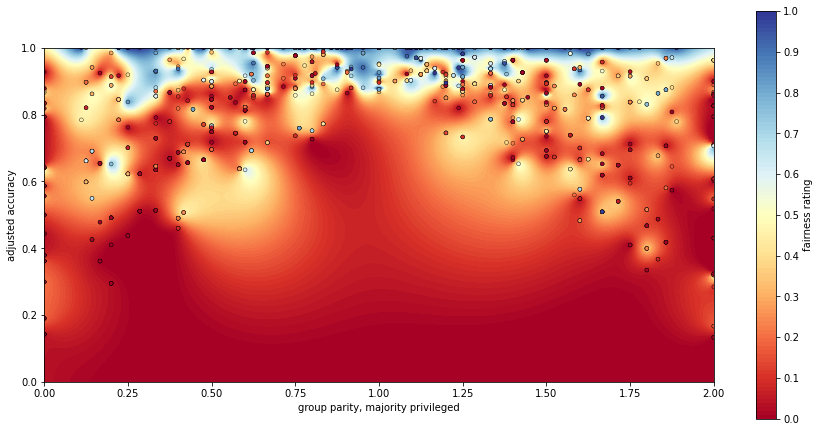

In [5]:
y = df_sel['question.adj_accuracy']
x = df_sel['question.cv']
z = df_sel['rating']

print_heatmap(x, y, z, xlabel="group parity, majority privileged", ylabel="adjusted accuracy")

Mean std. dev.: 0.22553664197871948


<ipython-input-4-508ebd3768c1>:56: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(z_values, axis=2)
/home/georg/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


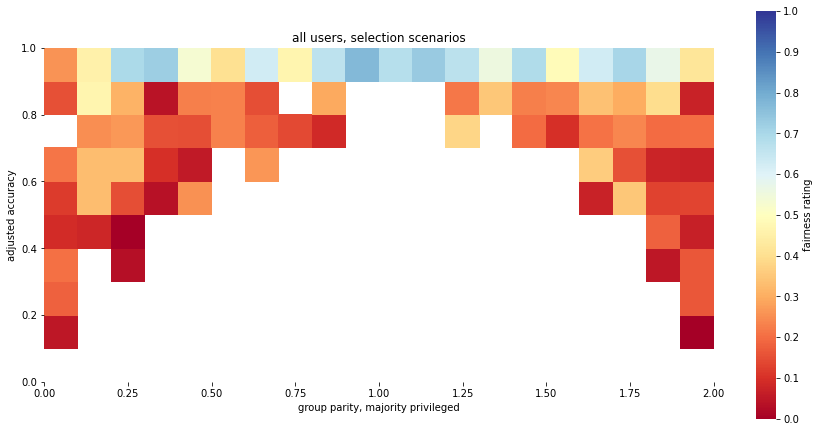

In [6]:
print_discrete_heatmap(data=df_sel, x='question.cv', y='question.adj_accuracy',
                       xlabel="group parity, majority privileged",
                       ylabel="adjusted accuracy",
                       title="all users, selection scenarios")

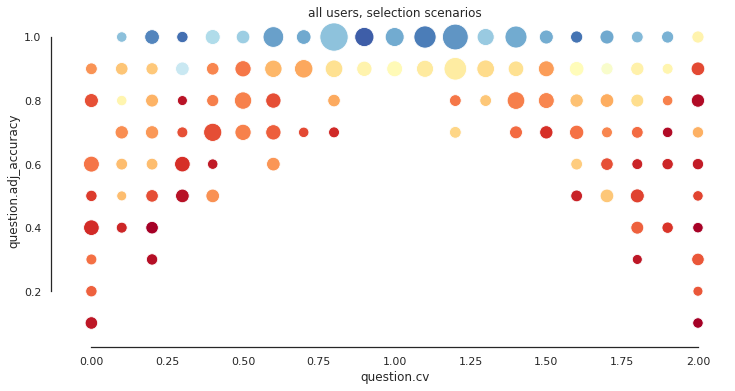

In [7]:
print_discrete_scaled_heatmap(data = df_sel, x='question.cv', y='question.adj_accuracy',
                              title="all users, selection scenarios")

Mean std. dev.: 0.2292452906364556


<ipython-input-4-508ebd3768c1>:56: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(z_values, axis=2)
/home/georg/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


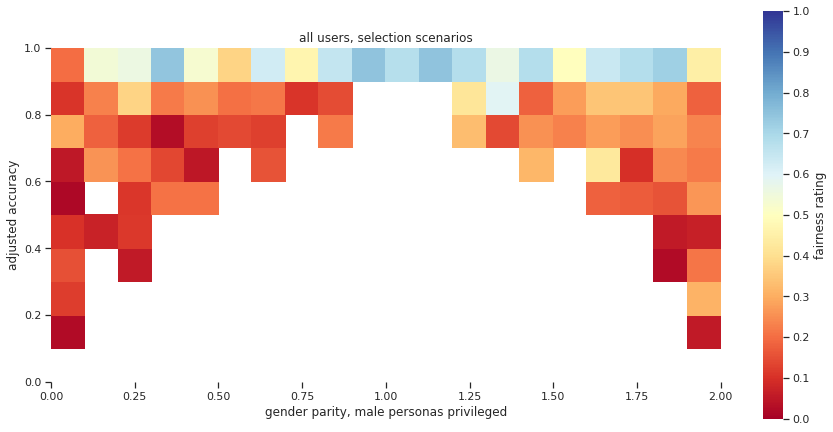

In [8]:
print_discrete_heatmap(data=df_sel, x='question.gender_cv', y='question.adj_accuracy',
                       xlabel="gender parity, male personas privileged",
                       ylabel="adjusted accuracy",
                       title="all users, selection scenarios")

Mean std. dev.: 0.23210307956883477


<ipython-input-4-508ebd3768c1>:56: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(z_values, axis=2)


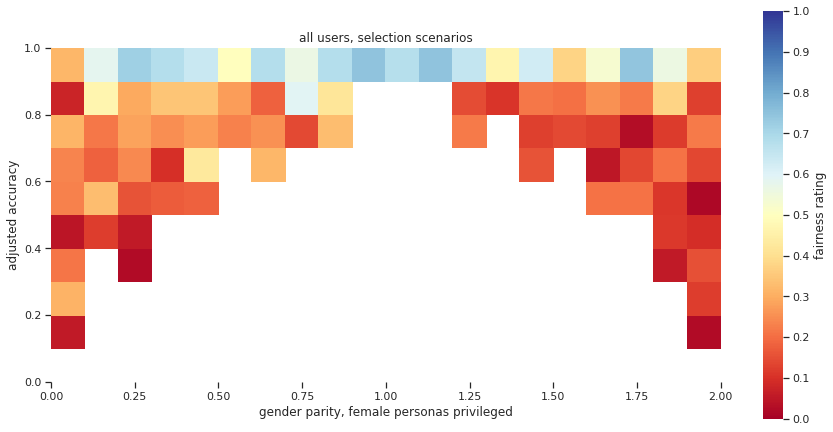

In [9]:
print_discrete_heatmap(data=df_sel, x='question.inverse_gender_cv', y='question.adj_accuracy',
                       xlabel="gender parity, female personas privileged",
                       ylabel="adjusted accuracy",
                       title="all users, selection scenarios")

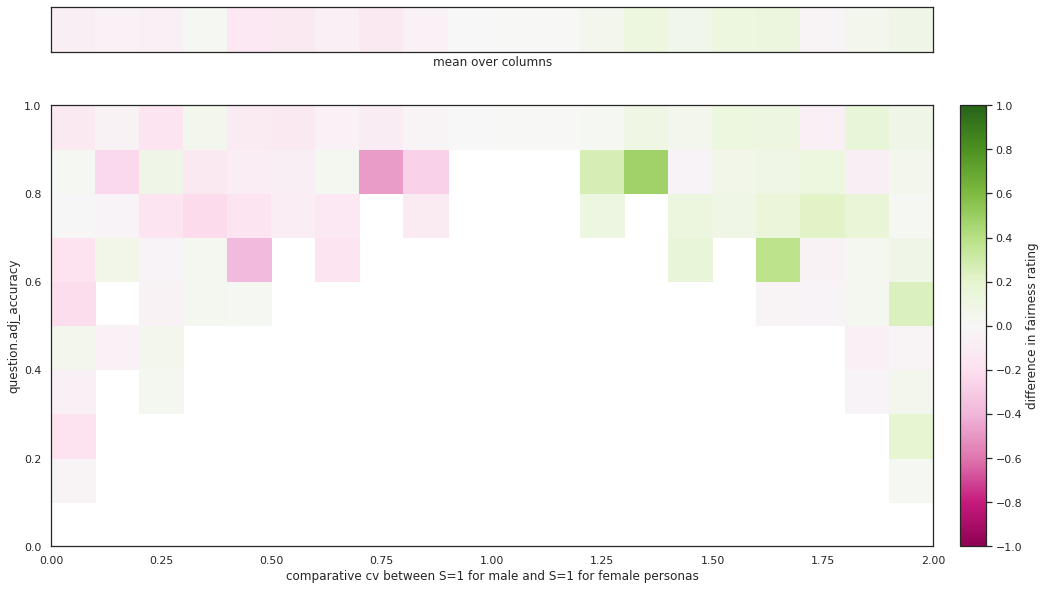

In [10]:
print_discrete_diff_heatmap(data=df_sel, x='question.gender_cv', x2='question.inverse_gender_cv',
                            y='question.adj_accuracy',
                            xlabel="comparative cv between S=1 for male and S=1 for female personas",
                            title="all users, selection scenarios")

people prefer unfair selections in which proportionally more women get selected over unfair selections that benefit men

Mean std. dev.: 0.18658918423277257


<ipython-input-4-508ebd3768c1>:56: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(z_values, axis=2)


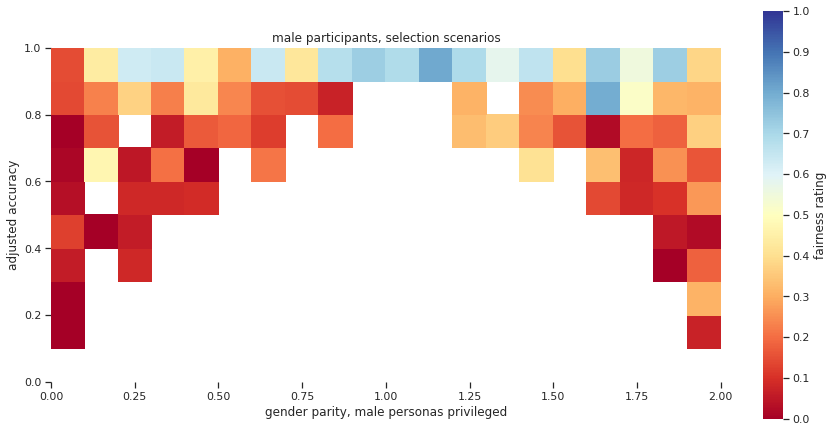

In [11]:
print_discrete_heatmap(data=df_sel[df_sel['user.gender'] == 'male'],
                       x='question.gender_cv', y='question.adj_accuracy',
                       xlabel="gender parity, male personas privileged",
                       ylabel="adjusted accuracy",
                       title="male participants, selection scenarios")

Mean std. dev.: 0.1910707008310817


<ipython-input-4-508ebd3768c1>:56: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(z_values, axis=2)


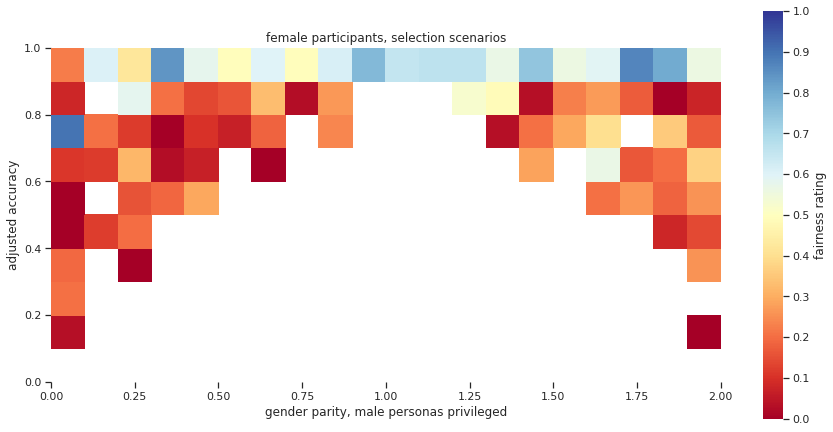

In [12]:
print_discrete_heatmap(data=df_sel[df_sel['user.gender'] == 'female'],
                       x='question.gender_cv', y='question.adj_accuracy',
                       xlabel="gender parity, male personas privileged",
                       ylabel="adjusted accuracy",
                       title="female participants, selection scenarios")

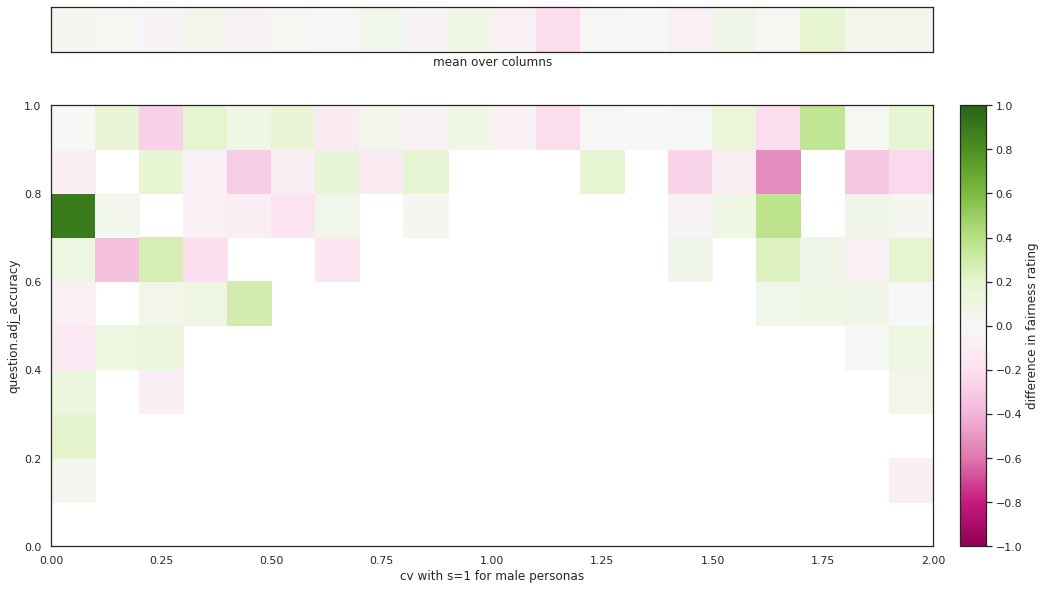

In [13]:
print_discrete_diff_heatmap(data=df_sel[df_sel['user.gender'] == 'female'],
                            x='question.gender_cv', y='question.adj_accuracy',
                            data2=df_sel[df_sel['user.gender'] == 'male'],
                            xlabel="cv with s=1 for male personas",
                            title="comparing female and male participants, selection scenarios")

**maybe** women prefer unfair selections in which proportionally more women get selected more so than men do

<ipython-input-20-bf2546a8c237>:56: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(z_values, axis=2)


Mean std. dev.: 0.1761883245550463


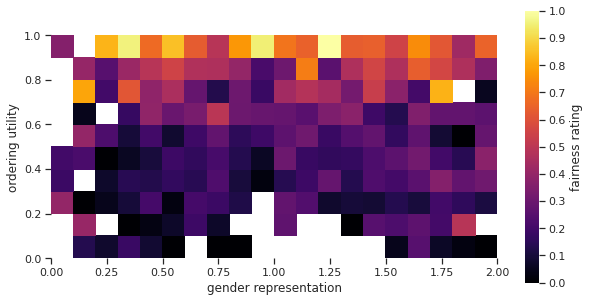

In [21]:
print_discrete_heatmap(data=df_ran, x='question.gender_rND', y='question.ordering_utility',
                       xlabel="gender representation",
                       ylabel="ordering utility", cmap=plt.cm.inferno)

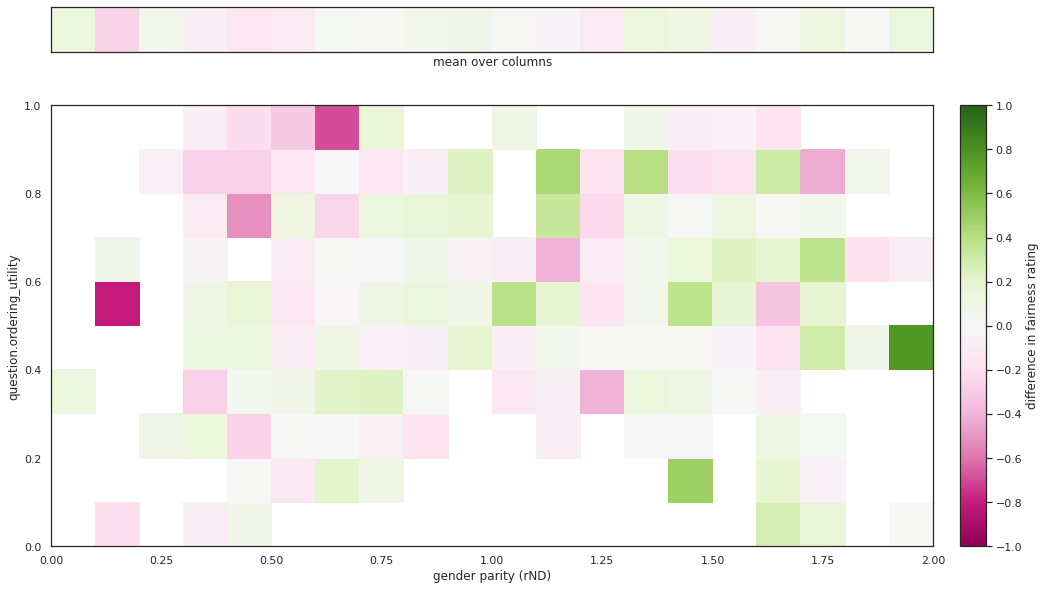

In [15]:
print_discrete_diff_heatmap(data=df_ran[df_ran['user.gender'] == 'female'],
                            x='question.gender_rND', y='question.ordering_utility',
                            data2=df_ran[df_ran['user.gender'] == 'male'],
                            xlabel="gender parity (rND)",
                            title="comparing female and male participants, ranking scenarios")

there appears to be a similar difference between men and women rating ranking senarios